In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12.0, 7.0)
import scipy.sparse
import operator

In [4]:
def score(book_list, scores):
    s = np.zeros(len(book_list), dtype=int)
    for i, b in enumerate(book_list):
        s[i] = scores[b]
    s = np.sort(s)[::-1]
    return s


def possible_score(tps, rate, score, d):
    return np.sum(score[:(d - tps) * rate])


def do_python(filenb):
    filename = 'data/' + str(filenb) + '.txt'

    f = open(filename,"r")
    B, L, D = map(int, f.readline().split())
    scores = np.array(list(map(int, f.readline().split())))
    max_score = sum(scores)
    print(f'max score: {max_score}\ndays: {D} ')
    libraries = []

    for i in range(L):
        nb, tps, rate = map(int, f.readline().split())
        books = list(map(int, f.readline().split()))
        libraries.append({
            'nb': nb,
            'tps': tps,
            'rate': rate,
            'books': books
        })
    
    idf = np.zeros(B, dtype=int)
    
    for lib in libraries:
        idf[lib['books']] += 1
        
    def score_idf(books, idf=idf, scores=scores):
        return np.sum(scores[books] / idf[books])

                
    lib_pd = pd.DataFrame(libraries)
    lib_pd['scores'] = lib_pd['books'].apply(lambda x: score(x, scores))
    lib_pd['sum_scores'] = lib_pd['scores'].apply(np.sum)
    return lib_pd, D, B, L, idf, scores, max_score


def build_book_to_lib(libs):
    book_to_lib = {}
    for i, bs in enumerate(libs['books']):
        for b in bs:
            if b not in book_to_lib:
                book_to_lib[b] = {'libs': set(), 'idf': 0}
            book_to_lib[b]['libs'].add(i)
    for b in book_to_lib.keys():
        book_to_lib[b]['idf'] = len(book_to_lib[b]['libs'])
    return book_to_lib

In [5]:
import time

class Book(object):
    def __init__(self, ide, lib_ids, score):
        self.libs = set(lib_ids)
        self.id = ide
        self.score = score
        self.idf = len(self.libs)
    
    @property
    def sort_score(self):
        return self.score #/ np.log(self.idf + 1)
    
    def update(self, libs, idf):
        self.libs.difference_update(libs)
        self.idf = len(self.libs)
        idf[self.id] = self.idf # update idf
        

class Library(object):
    def __init__(self, ide, book_ids, tps, rate):
        self.id = ide
        self.book_ids = set(book_ids)
        self.tps = tps
        self.rate = rate
    
    def build_score_sum(self, scores):
        self.score_sum = np.sum(scores[list(self.book_ids)])
    
    def build_sum_idf(self, idf):
        self.sum_idf = np.sum(1 / (idf[list(self.book_ids)] - 0.999))
    
    def build_sort_score(self, D, true_score=False, books=None):
        n = min((D - self.tps) * self.rate, self.nb) # number of books you can read
        if true_score:
            score_books = sorted([books[i].sort_score for i in self.book_ids], reverse=True)
            score = np.sum(score_books[:n])
            return score / (self.tps**(4 / 5))
        # self.sort_score =  self.rate * self.score_sum / self.tps
        # return (n * self.score_sum / self.nb) / (self.tps**(3.5 / 5)) 
        return n * self.sum_idf #/ self.tps**2
    
    def update(self, books, scores, idfs, D):
        self.book_ids.difference_update(books)
        self.build_score_sum(scores)
        self.build_sum_idf(idfs)
        
    @property
    def nb(self):
        return len(self.book_ids)
    
    def __str__(self):
        return f"{self.id} - {len(self.book_ids)} - {self.tps} - {self.rate}"
    
    def __repr__(self):
        return f"{self.id} - {len(self.book_ids)} - {self.tps} - {self.rate}"

        
class LibraryEnsemble(object):
    
    def __init__(self, filenb):
        lib_pd, self.remain_D, self.B, self.L, self.idf, self.scores, self.max_score = do_python(filenb)
        book_to_lib = build_book_to_lib(lib_pd)
        self.filenb = filenb
        
        self.libraries = {}
        self.books = {}
        self.score = 0
        self.nb_lib = 0
        
        for i, lib in lib_pd.iterrows():
            l = Library(i, lib['books'], lib['tps'], lib['rate'])
            l.build_sum_idf(idf=self.idf)
            l.build_score_sum(self.scores)
            self.libraries[i] = l
        
        self.library_ids = set(self.libraries.keys()) 
            
        
        for b, v in book_to_lib.items():
            self.books[b] = Book(b, v['libs'], self.scores[b])
        self.book_ids = set(self.books.keys()) # set of ids of active books

  
        del lib_pd
        del book_to_lib

        self.choices = ""
    
    def update_choices(self, lib, book_read_from_lib):
        self.choices += "{} {}\n".format(lib.id, len(book_read_from_lib)) + " ".join(map(str, book_read_from_lib)) + "\n"
        self.nb_lib += 1
    
    def choose(self, t_update=10, verbose=False, get_score=True, true_lib_score=False):
        t = time.time()

        sorted_library_ids = sorted(self.library_ids, key=lambda lib_id: self.libraries[lib_id].build_sort_score(self.remain_D, true_lib_score, self.books), reverse=False)
        
        removed_lib_ids = set()
        removed_books_ids = set()
        read_books_ids = set()
        all_read_books_ids = set()
        books_to_update = set() # even if it wasn't read you can update idf
                
        while len(sorted_library_ids) > 0 and self.remain_D > 0:
            lib = self.libraries[sorted_library_ids.pop()]
            removed_lib_ids.add(lib.id)
            if self.remain_D <= lib.tps or lib.nb == 0: # if there is nothing to read or not enough time to read anything
                if lib.nb == 0 and self.remain_D > lib.tps:
                    print("No book in selected lib !")
                else:
                    books_to_update.update(lib.book_ids)
                continue
            self.remain_D -= lib.tps
            nb_removed_from_lib = min(self.remain_D * lib.rate, lib.nb)
            if nb_removed_from_lib == lib.nb: # if we got enough time to add all books
                read_books_ids.update(lib.book_ids)
                book_read_from_lib = list(lib.book_ids)
            else: # otherwise we sort them to select the most precious ones
                book_read_from_lib = sorted(lib.book_ids, key=lambda x: self.books[x].sort_score, reverse=True)
                read_books_ids.update(book_read_from_lib[:nb_removed_from_lib])
            self.update_choices(lib, book_read_from_lib)
            books_to_update.update(lib.book_ids)
            
            if len(removed_lib_ids) >= t_update or self.remain_D < 2000:
                for book_id in books_to_update:
                    self.books[book_id].update(removed_lib_ids, self.idf) 
                    # check if some library still contains this book
                    if self.idf[book_id] == 0:
                        removed_books_ids.add(book_id)
                    
                for lib_id in self.library_ids:
                    lib = self.libraries[lib_id]
                    lib.update(read_books_ids, self.scores, self.idf, self.remain_D)
                    if lib.nb == 0:
                        removed_lib_ids.add(lib.id)
                
                self.library_ids.difference_update(removed_lib_ids)
                
                removed_books_ids.update(read_books_ids)
                self.book_ids.difference_update(removed_books_ids) # update list of
                
                if get_score:
                    score_update = np.sum(self.scores[list(read_books_ids.difference(all_read_books_ids))])
                    self.score += score_update

                all_read_books_ids.update(read_books_ids)
                
                if verbose:
                    print("{} days remain - {} books removed ({} / {}) - {} libraries removed ({} / {}) - score imroved {} ({} / {}) - {:.1f}s".format(self.remain_D, len(read_books_ids), len(all_read_books_ids), self.B, len(removed_lib_ids), self.L - len(self.library_ids), self.L, score_update, self.score, self.max_score, time.time() - t))
                
                t = time.time()
   
                removed_lib_ids = set()
                read_books_ids = set()
                removed_books_ids = set()
                books_to_update = set()
                
                sorted_library_ids = sorted(self.library_ids, key=lambda lib_id: self.libraries[lib_id].build_sort_score(self.remain_D, true_lib_score, self.books), reverse=False)


        if get_score:
            all_read_books_ids.update(read_books_ids)
            self.score = np.sum(self.scores[list(all_read_books_ids)])
        
            print(f"{len(all_read_books_ids)} read books - score: {self.score} / {self.max_score}")
    
    def print_to_file(self):
        print("Start saving file {}".format(self.filenb))
        f = open("results/jupy/{}.txt".format(self.filenb), "w+")
        f.write("{}\n".format(self.nb_lib))
        f.write(self.choices)
        f.close()
        print("End saving file")
        

In [9]:
l = LibraryEnsemble(6)
l.choose(t_update=1, verbose=True, true_lib_score=False)
l.print_to_file()

max score: 40111142
days: 700 
576 days remain - 955 books removed (955 / 100000) - 1 libraries removed (1 / 1000) - score imroved 390374 (390374 / 40111142) - 0.1s
500 days remain - 973 books removed (1928 / 100000) - 1 libraries removed (2 / 1000) - score imroved 404419 (794793 / 40111142) - 0.1s
314 days remain - 836 books removed (2764 / 100000) - 1 libraries removed (3 / 1000) - score imroved 345584 (1140377 / 40111142) - 0.1s
235 days remain - 948 books removed (3712 / 100000) - 1 libraries removed (4 / 1000) - score imroved 373396 (1513773 / 40111142) - 0.1s
157 days remain - 886 books removed (4598 / 100000) - 1 libraries removed (5 / 1000) - score imroved 353060 (1866833 / 40111142) - 0.1s
108 days remain - 658 books removed (5256 / 100000) - 1 libraries removed (6 / 1000) - score imroved 264620 (2131453 / 40111142) - 0.1s
58 days remain - 522 books removed (5778 / 100000) - 1 libraries removed (7 / 1000) - score imroved 283535 (2414988 / 40111142) - 0.1s
27 days remain - 162 

In [373]:
from IPython.display import clear_output

T_update = [0, 1, 1, 10, 50, 1, 1]
for i in range(1, 7):
    l = LibraryEnsemble(i)
    clear_output()
    t_update = 10 if i == 3 else 1
    l.choose(T_update[i], verbose=True)
    l.print_to_file()

199 days remain, 398 books removed, 1 libraries removed - score: 52035
198 days remain, 396 books removed, 1 libraries removed - score: 104774
197 days remain, 394 books removed, 1 libraries removed - score: 155856
196 days remain, 392 books removed, 1 libraries removed - score: 207297
195 days remain, 390 books removed, 1 libraries removed - score: 258232
194 days remain, 388 books removed, 1 libraries removed - score: 308851
193 days remain, 386 books removed, 1 libraries removed - score: 357568
192 days remain, 380 books removed, 1 libraries removed - score: 407073
191 days remain, 382 books removed, 1 libraries removed - score: 457223
190 days remain, 380 books removed, 1 libraries removed - score: 506118
189 days remain, 378 books removed, 1 libraries removed - score: 553918
188 days remain, 376 books removed, 1 libraries removed - score: 602127
187 days remain, 374 books removed, 1 libraries removed - score: 648583
186 days remain, 372 books removed, 1 libraries removed - score: 

In [8]:
libs = []
days = []

for i in range(1, 7):
    lib, d, B, L, idf, scores, max_score = do_python(i)
    libs.append(lib)
    days.append(d)
    

max score: 21
days: 7 
max score: 10000000
days: 1000 
max score: 30076415
days: 100000 
max score: 5109000
days: 30001 
max score: 12548648
days: 200 
max score: 40111142
days: 700 


In [9]:
libs[2]

,nb,tps,rate,books,scores,sum_scores,possible_scores,score_idf
0,13,344,33474,"[45608, 94192, 70546, 4346, 45948, 94356, 6990...","[568, 537, 518, 503, 434, 403, 318, 282, 110, ...",3867,3867,2276.833333
1,19,966,53538,"[30294, 64718, 22277, 51943, 75323, 26185, 431...","[554, 545, 466, 445, 429, 340, 298, 274, 272, ...",4651,4651,1833.500000
2,18,1000,27830,"[99122, 81548, 95109, 7100, 35387, 2833, 88815...","[589, 588, 585, 572, 520, 452, 412, 404, 389, ...",6303,6303,2991.333333
3,14,276,8039,"[49233, 54205, 19769, 93556, 4982, 43193, 2341...","[538, 531, 484, 377, 355, 354, 351, 334, 269, ...",4497,4497,1654.616667
4,12,869,717,"[88055, 84490, 39112, 16808, 75782, 24927, 141...","[597, 588, 577, 539, 506, 390, 353, 329, 298, ...",4348,4348,2234.000000
...,...,...,...,...,...,...,...,...
9995,18,648,69743,"[70893, 46238, 1518, 37631, 49403, 89542, 8636...","[581, 532, 508, 420, 416, 375, 346, 345, 343, ...",5606,5606,2256.650000
9996,16,736,17734,"[83827, 6242, 85586, 31883, 43344, 6423, 67187...","[569, 568, 545, 503, 466, 466, 465, 453, 427, ...",5635,5635,2839.100000
9997,12,668,90986,"[10870, 28529, 44061, 69237, 47148, 53944, 855...","[546, 546, 527, 328, 223, 209, 179, 158, 137, ...",3029,3029,1662.600000
9998,19,955,4483,"[64416, 73064, 53242, 865, 93052, 85931, 17066...","[600, 594, 536, 534, 528, 523, 514, 496, 481, ...",6906,6906,3687.433333


In [167]:
def apply_to_all(libs, fct, **kwargs):
    for i, lib in enumerate(libs):
        fct(lib, i + 1, **kwargs)

def plot_for_libs(libs, fct, **kwargs):
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()
    for i, lib in enumerate(libs):
        fct(lib, axes[i], i + 1, **kwargs)
    plt.show()

In [194]:
def plot_hist(lib, ax, i, label=None):
    ax.hist(lib[label])
    ax.set_xlabel(str(i)  + ' - {}'.format(label))
    
def scatter_2(lib, ax, i, labelx='tps', labely='rate', t=None):
    ax.scatter(lib[labelx], lib[labely])
    ax.set_xlabel(str(i)  + ' - {} - {}'.format(labelx, t))
    ax.set_ylabel(str(i)  + ' - {}'.format(labely))
    
def count_possible(lib, i):
    print('{} - {} possibles'.format(i, lib['possible_scores'].sum()))

In [177]:
apply_to_all(libs, count_possible)

1 - 31 possibles
2 - 9881900 possibles
3 - 45209100 possibles
4 - 14352000 possibles
5 - 42081259 possibles
6 - 204421248 possibles


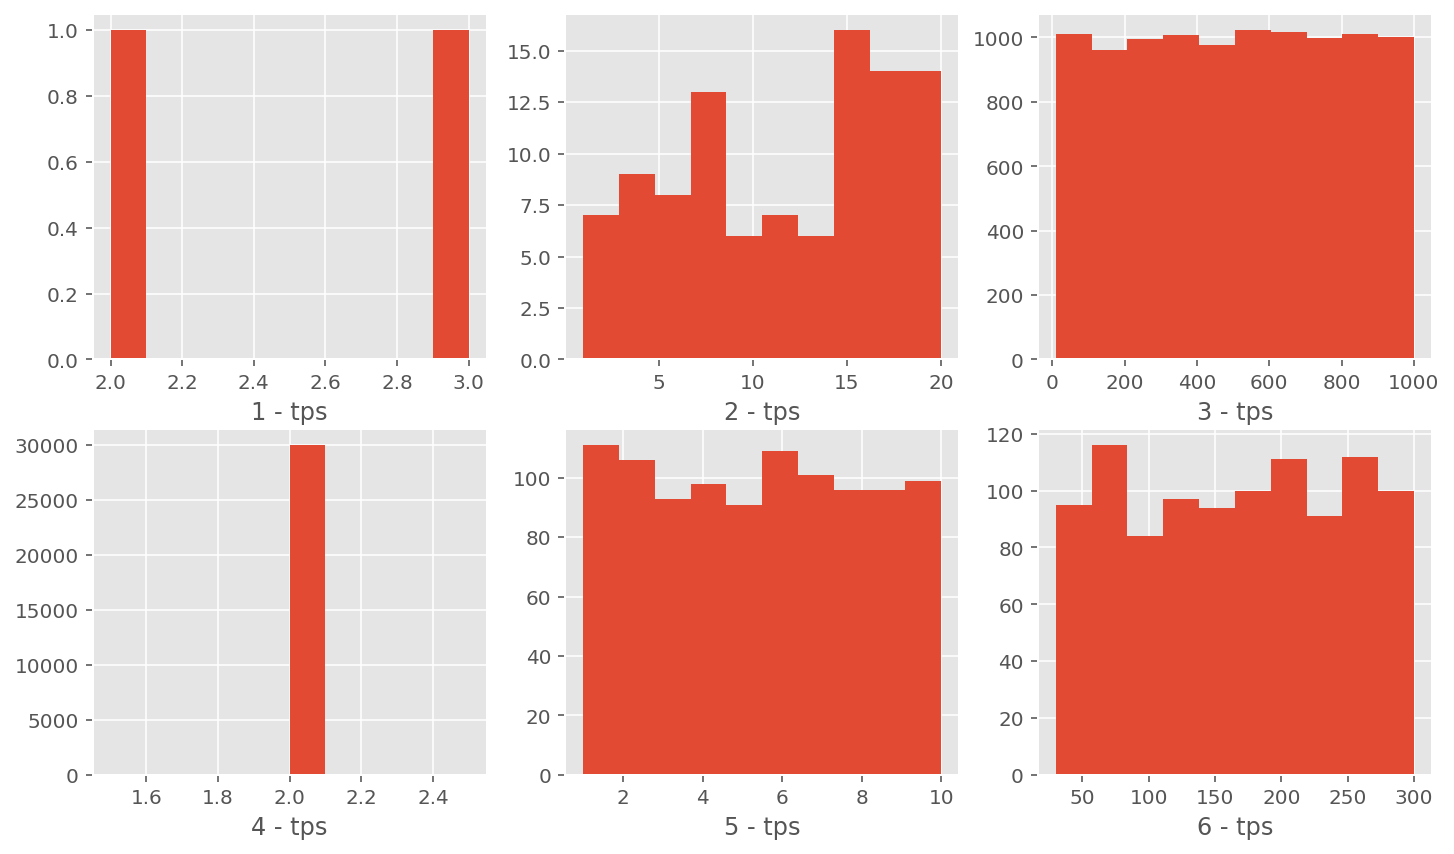

In [185]:
plot_for_libs(libs, plot_hist, **{'label': 'tps'})

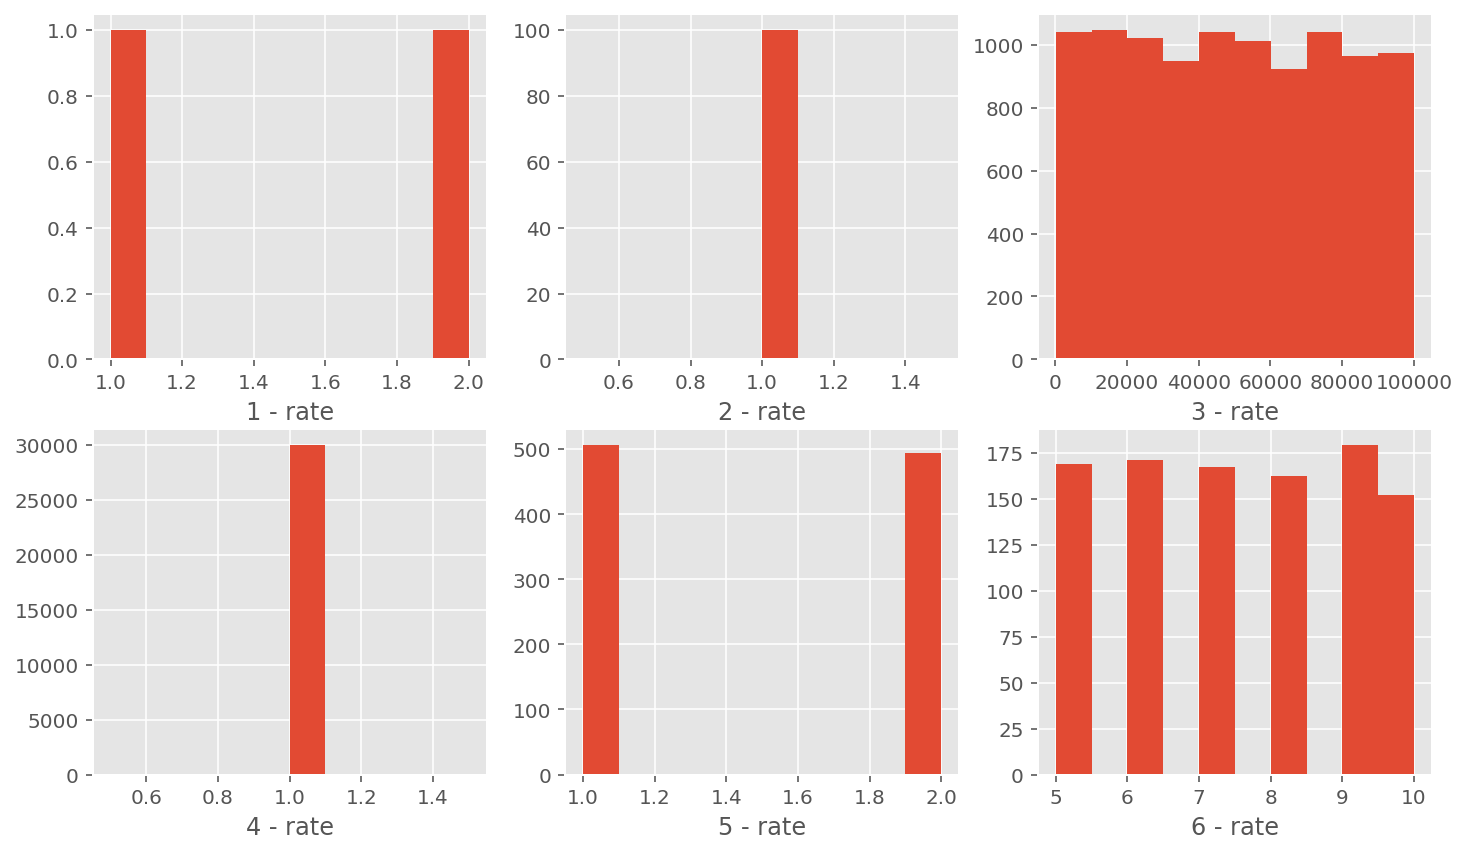

In [186]:
plot_for_libs(libs, plot_hist, **{'label': 'rate'})

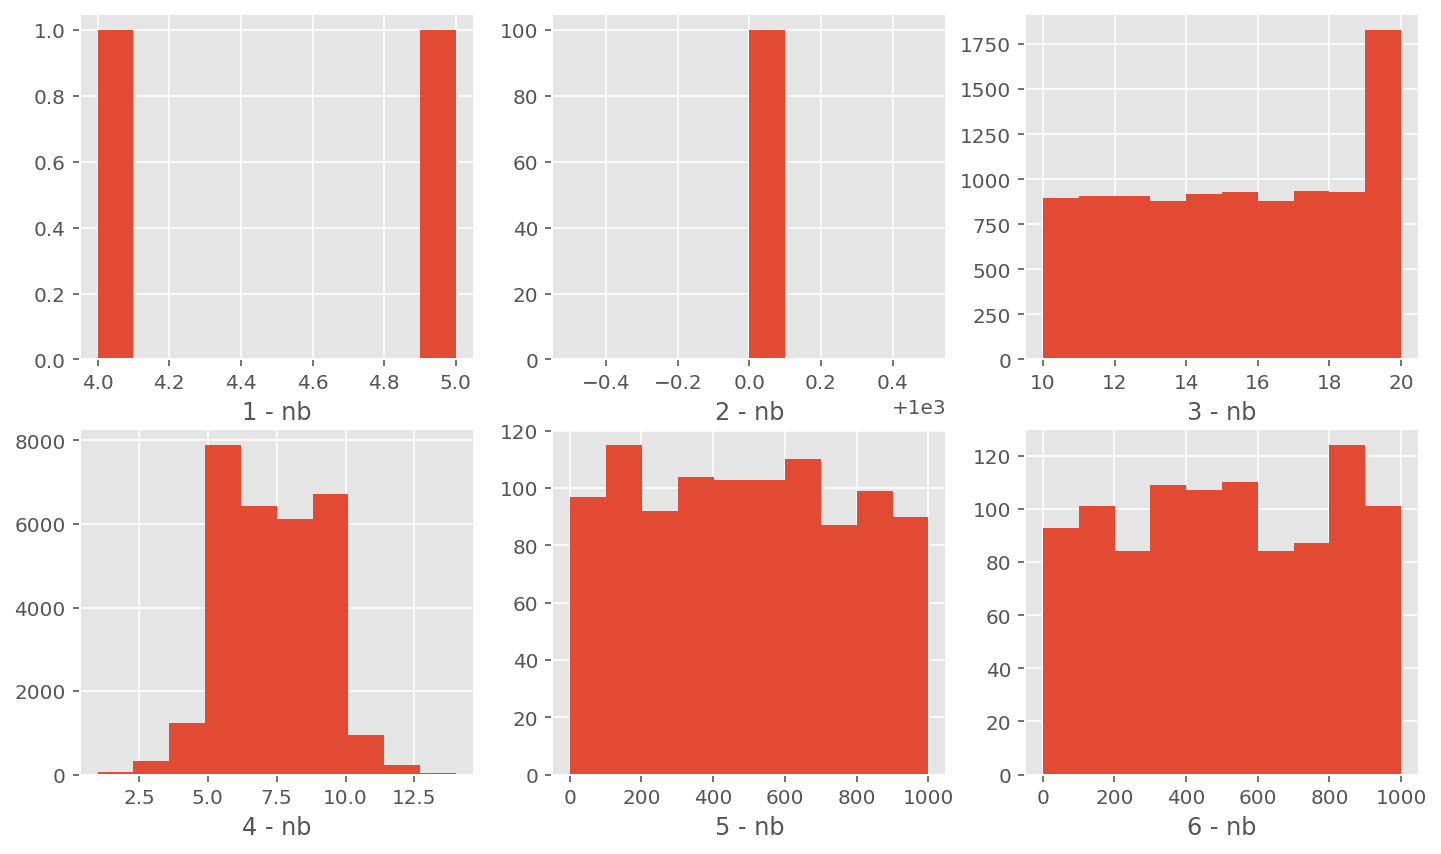

In [187]:
plot_for_libs(libs, plot_hist, **{'label': 'nb'})

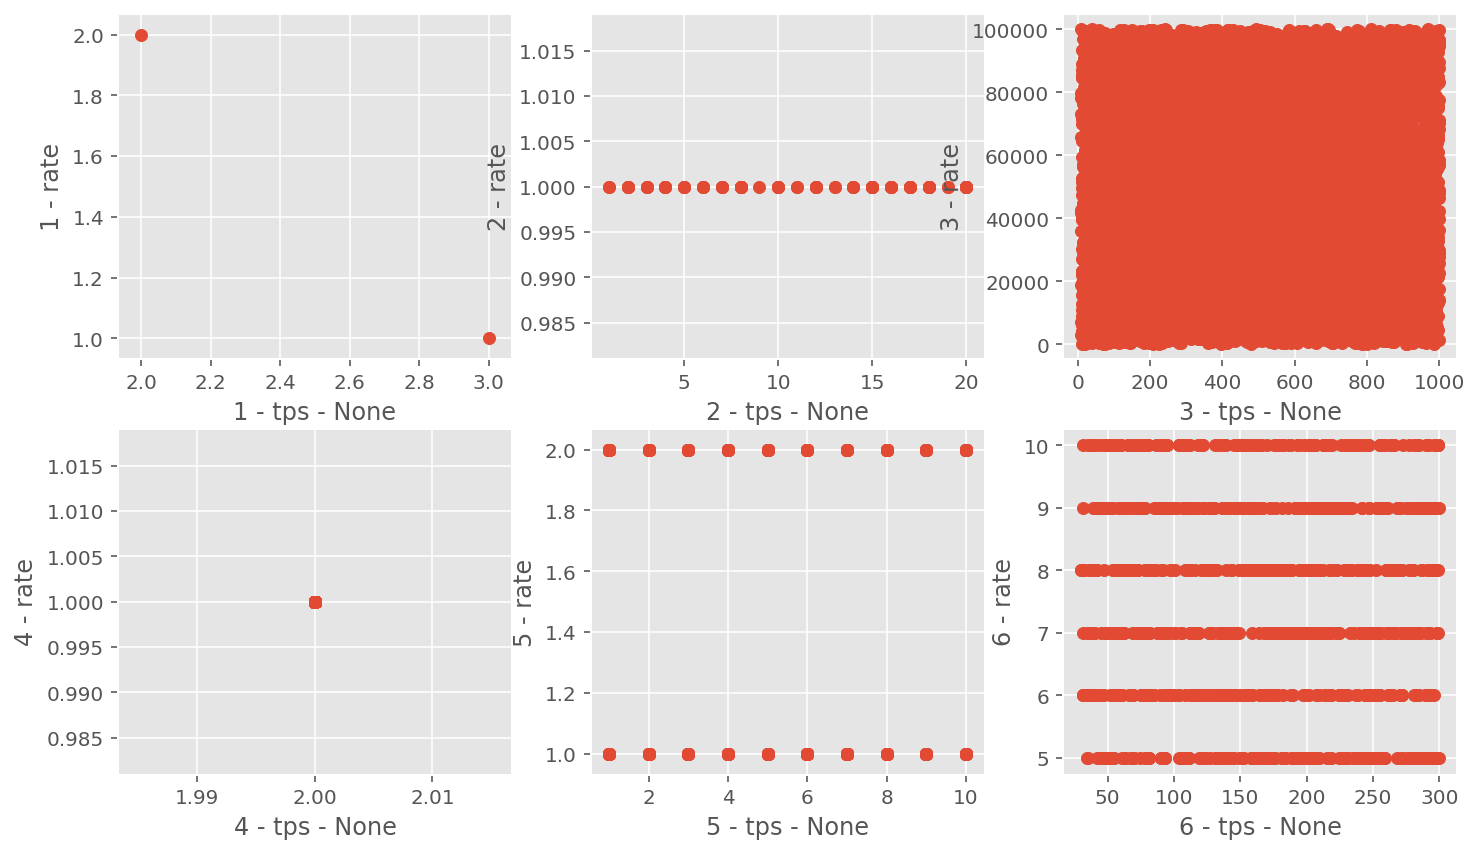

In [195]:
plot_for_libs(libs, scatter_2)

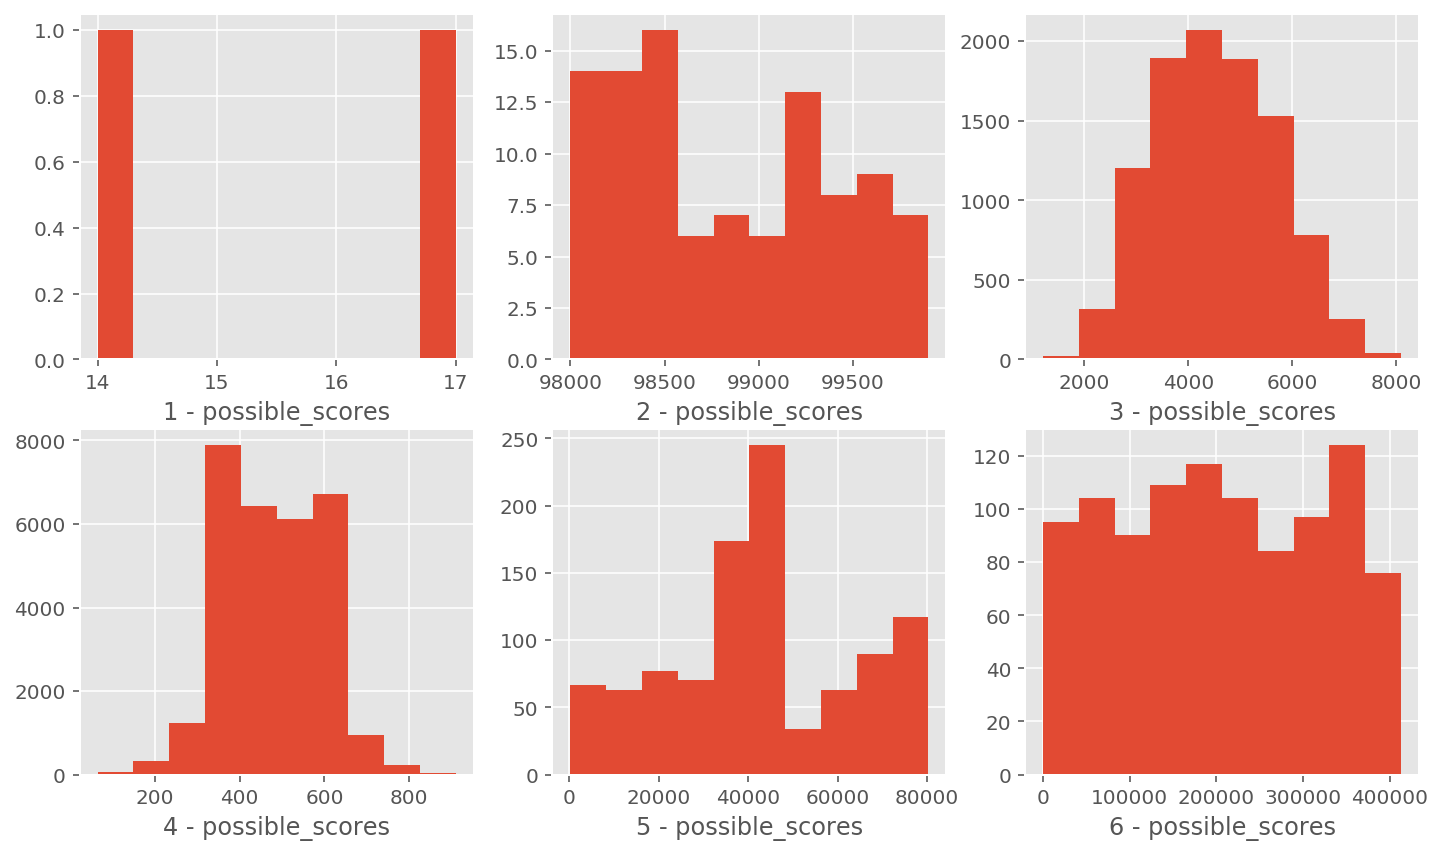

In [196]:
plot_for_libs(libs, plot_hist, **{'label': 'possible_scores'})